# Analyze the output files from ReadFish

Adapt the file paths accordingly.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pysam
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from simreaduntil.shared_utils.nanosim_parsing import NanoSimId


In [19]:
# run_dir = Path("runs/enrich_usecase/full_run_sampler_per_window/simulator_run/")
run_dir = Path("/is/cluster-test/fast/mmordig/ont_project/runs/enrich_usecase/readfish_exp/results_readfishexp_realreads/simulator_run/")
# run_dir = Path("/home/mmordig/ont_project_all/ont_project/runs/enrich_usecase/readfish_exp/results_readfishexp_realreads_withflanking/simulator_run")

## Check whether ReadFish is mapping the reads correctly by parsing the NanoSim id

In [15]:
mapping_paf_file = run_dir / "mapping.paf"

df = pd.read_csv(mapping_paf_file, sep="\t", header=None, usecols=[0, 1, 2, 3, 4, 5, 6, 7, 8], names=["read_id", "read_length", "read_start", "read_end", "strand", "contig_name", "contig_length", "contig_start", "contig_end"])
df.head()

,read_id,read_length,read_start,read_end,strand,contig_name,contig_length,contig_start,contig_end
0,chr1_26454210_aligned_proc0:64_F_0_1535_0,263,0,263,+,chr1,248387328,26454210,26454469
1,chr8_35080996_aligned_proc0:45_F_0_11151_0,323,3,323,+,chr8,146259331,35081000,35081331
2,chr5_119262799_aligned_proc0:51_F_0_7992_0,265,0,265,+,chr5,182045439,119262799,119263072
3,chr2_26169279_aligned_proc0:26_F_0_10295_0,343,0,334,+,chr2,242696752,26169279,26169617
4,chr3_117116174_aligned_proc0:36_F_0_7402_0,342,0,342,+,chr3,201105948,117116174,117116526


In [16]:
df["chrom"] = df["read_id"].apply(lambda read_id: NanoSimId.from_str(read_id).chrom)
df["mapping_correct"] = df["chrom"] == df["contig_name"]
df.head()

,read_id,read_length,read_start,read_end,strand,contig_name,contig_length,contig_start,contig_end,chrom,mapping_correct
0,chr1_26454210_aligned_proc0:64_F_0_1535_0,263,0,263,+,chr1,248387328,26454210,26454469,chr1,True
1,chr8_35080996_aligned_proc0:45_F_0_11151_0,323,3,323,+,chr8,146259331,35081000,35081331,chr8,True
2,chr5_119262799_aligned_proc0:51_F_0_7992_0,265,0,265,+,chr5,182045439,119262799,119263072,chr5,True
3,chr2_26169279_aligned_proc0:26_F_0_10295_0,343,0,334,+,chr2,242696752,26169279,26169617,chr2,True
4,chr3_117116174_aligned_proc0:36_F_0_7402_0,342,0,342,+,chr3,201105948,117116174,117116526,chr3,True


In [17]:
fraction_correct = sum(df["mapping_correct"]) / len(df)
fraction_correct

0.8156957759568824

Text(0, 0.5, 'Cumulative mapping correct')

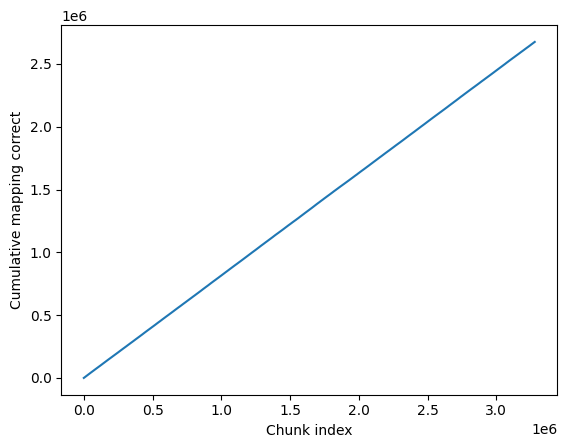

In [18]:
# can be used to see if the mapping fails initially (for small chunk indices) pointing to the mapper being overwhelmed by the sheer number of channels
df["chunk_idx"] = np.arange(len(df))
df["cum_mapping_correct"] = df["mapping_correct"].cumsum()
fig, ax = plt.subplots()
sns.lineplot(data=df, x="chunk_idx", y="cum_mapping_correct", ax=ax)
ax.set_xlabel("Chunk index")
ax.set_ylabel("Cumulative number of correct mappings")

## Analyze chunk log

We take the last decision for each read.

In [20]:
chunk_log = run_dir / "chunk_log.txt"
chunk_df = pd.read_csv(chunk_log, sep="\t")
first_time = chunk_df["start_analysis"].min()
chunk_df["start_analysis"] -= first_time
chunk_df["end_analysis"] -= first_time
chunk_df["timestamp"] -= chunk_df["timestamp"].min() # different timer implementation
# last decision per read_id

chunk_df.head()

,client_iteration,read_in_loop,read_id,channel,read_number,seq_len,counter,mode,decision,condition,min_threshold,count_threshold,start_analysis,end_analysis,timestamp
0,12,1,chr4_79091622_aligned_proc0:17_R_0_10859_0,126,chr4_79091622_aligned_proc0:17_R_0_10859_0,319,1,control,True,control,False,False,0.000000,0.000864,0.000000
1,12,2,chr1_51922780_aligned_proc0:2_R_0_35088_0,15,chr1_51922780_aligned_proc0:2_R_0_35088_0,246,1,control,True,control,False,False,0.001536,0.001548,0.000683
2,12,3,chr1_26454210_aligned_proc0:64_F_0_1535_0,482,chr1_26454210_aligned_proc0:64_F_0_1535_0,263,1,single_off,unblock,enrich_chr_16_20,False,False,0.001865,0.004453,0.003588
3,12,4,chr8_35080996_aligned_proc0:45_F_0_11151_0,314,chr8_35080996_aligned_proc0:45_F_0_11151_0,323,1,single_off,unblock,enrich_chr_9_14,False,False,0.004892,0.005007,0.004142
4,12,5,chr5_119262799_aligned_proc0:51_F_0_7992_0,375,chr5_119262799_aligned_proc0:51_F_0_7992_0,265,1,single_off,unblock,enrich_chr_9_14,False,False,0.005365,0.005459,0.004594


In [21]:
# check whether some reads have contradicting decisions (except for "proceed")
df1 = chunk_df[chunk_df["decision"] != "proceed"]
nb_decisions_per_read = df1.groupby("read_id", observed=True)["decision"].nunique()
nb_decisions_per_read = nb_decisions_per_read[nb_decisions_per_read > 1]
if len(nb_decisions_per_read) > 0:
    print(f"The following reads have contradicting decisions: {nb_decisions_per_read.index.values}")

The following reads have contradicting decisions: ['chr10_46560475_aligned_proc1:8557_R_0_10144_0'
 'chr10_51022679_aligned_proc0:15129_R_0_4742_0'
 'chr10_57355202_aligned_proc1:2861_R_0_24476_0'
 'chr10_95690626_aligned_proc0:22338_F_0_13966_0'
 'chr11_13489989_aligned_proc1:5601_F_0_3642_0'
 'chr11_3443736_aligned_proc0:17762_F_0_1555_0'
 'chr11_65986646_aligned_proc0:44259_R_0_8924_0'
 'chr11_67699121_aligned_proc1:32911_F_0_18565_0'
 'chr11_67773251_aligned_proc0:46991_F_0_1263_0'
 'chr11_79041662_aligned_proc1:11941_R_0_30699_0'
 'chr11_83978157_aligned_proc0:45408_F_0_988_0'
 'chr11_93901830_aligned_proc0:1066_R_0_30342_0'
 'chr12_100988723_aligned_proc1:9500_R_0_6199_0'
 'chr12_102809304_aligned_proc0:43933_R_0_9229_0'
 'chr12_18717659_aligned_proc1:22380_F_0_4309_0'
 'chr12_35213329_aligned_proc1:37488_F_0_10051_0'
 'chr12_50869782_aligned_proc1:10980_F_0_7198_0'
 'chr12_69368901_aligned_proc0:18483_R_0_7777_0'
 'chr13_48384073_aligned_proc1:42729_F_0_9275_0'
 'chr13_89341620_

In [22]:
chunk_df.sort_values("end_analysis", inplace=True)
chunk_df = chunk_df.groupby("read_id", observed=True).last().reset_index()
chunk_df.sort_values("end_analysis", inplace=True) # order not guaranteed

chunk_df["chrom"] = chunk_df["read_id"].apply(lambda read_id: NanoSimId.from_str(read_id).chrom)
chunk_df["is_rejection"] = chunk_df["decision"].apply(lambda x: x == "unblock")
chunk_df["is_stopreceiving"] = chunk_df["decision"].apply(lambda x: x == "stop_receiving")
chunk_df["cum_nb_rejections_per_chrom"] = chunk_df.groupby("chrom", observed=True)["is_rejection"].cumsum()
chunk_df["cum_nb_stopreceiving_per_chrom"] = chunk_df.groupby("chrom", observed=True)["is_stopreceiving"].cumsum()
chunk_df.head(10)

,read_id,client_iteration,read_in_loop,channel,read_number,seq_len,counter,mode,decision,condition,min_threshold,count_threshold,start_analysis,end_analysis,timestamp,chrom,is_rejection,is_stopreceiving,cum_nb_rejections_per_chrom,cum_nb_stopreceiving_per_chrom
1524713,chr4_79091622_aligned_proc0:17_R_0_10859_0,12,1,126,chr4_79091622_aligned_proc0:17_R_0_10859_0,319,1,control,True,control,False,False,0.000000,0.000864,0.000000,chr4,False,False,0,0
912219,chr1_51922780_aligned_proc0:2_R_0_35088_0,12,2,15,chr1_51922780_aligned_proc0:2_R_0_35088_0,246,1,control,True,control,False,False,0.001536,0.001548,0.000683,chr1,False,False,0,0
891103,chr1_26454210_aligned_proc0:64_F_0_1535_0,12,3,482,chr1_26454210_aligned_proc0:64_F_0_1535_0,263,1,single_off,unblock,enrich_chr_16_20,False,False,0.001865,0.004453,0.003588,chr1,True,False,1,0
1976384,chr8_35080996_aligned_proc0:45_F_0_11151_0,12,4,314,chr8_35080996_aligned_proc0:45_F_0_11151_0,323,1,single_off,unblock,enrich_chr_9_14,False,False,0.004892,0.005007,0.004142,chr8,True,False,1,0
1557842,chr5_119262799_aligned_proc0:51_F_0_7992_0,12,5,375,chr5_119262799_aligned_proc0:51_F_0_7992_0,265,1,single_off,unblock,enrich_chr_9_14,False,False,0.005365,0.005459,0.004594,chr5,True,False,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2115686,chr9_68107336_aligned_proc0:9822_R_0_6730_0,2449,22,254,chr9_68107336_aligned_proc0:9822_R_0_6730_0,200,12,exceeded_max_chunks_unblocked,exceeded_max_chunks_unblocked,enrich_chr_1_8,False,True,128.434243,128.434250,128.433385,chr9,False,False,263,133
282185,chr12_82202404_aligned_proc0:10025_R_0_11764_0,2449,24,269,chr12_82202404_aligned_proc0:10025_R_0_11764_0,342,1,single_on,stop_receiving,enrich_chr_9_14,False,False,128.434833,128.434892,128.434027,chr12,False,True,262,131
321565,chr13_28038874_aligned_proc0:10008_R_0_1007_0,2449,25,352,chr13_28038874_aligned_proc0:10008_R_0_1007_0,384,1,single_on,stop_receiving,enrich_chr_9_14,False,False,128.435300,128.435361,128.434495,chr13,False,True,204,106
1604331,chr5_175553425_aligned_proc0:10034_F_0_7706_0,2449,26,464,chr5_175553425_aligned_proc0:10034_F_0_7706_0,225,1,single_off,unblock,enrich_chr_16_20,False,False,128.435569,128.435622,128.434756,chr5,True,False,372,126


Text(0.5, 1.0, 'Cumulative number of stopreceiving per chromosome')

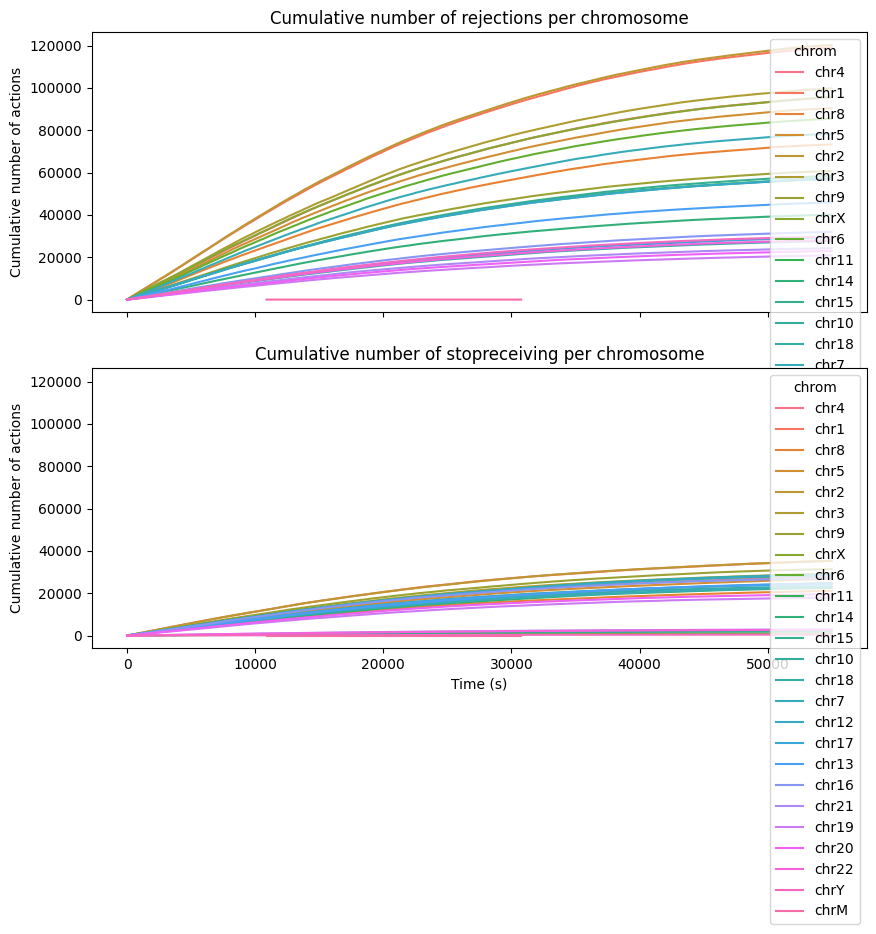

In [23]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 8), nrows=2, sharex=True, sharey=True)
sns.lineplot(data=chunk_df, x="end_analysis", y="cum_nb_rejections_per_chrom", hue="chrom", ax=ax1)
sns.lineplot(data=chunk_df, x="end_analysis", y="cum_nb_stopreceiving_per_chrom", hue="chrom", ax=ax2)
ax1.set_ylabel("Cumulative number of actions")
ax1.set_title("Cumulative number of rejections per chromosome")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Cumulative number of actions")
ax2.set_title("Cumulative number of stopreceiving per chromosome")

# on one plot, but legend not correct
# fig, ax = plt.subplots(figsize=(10, 5))
# sns.lineplot(data=chunk_df, x="end_analysis", y="cum_nb_rejections_per_chrom", hue="chrom", ax=ax)
# sns.lineplot(data=chunk_df, x="end_analysis", y="cum_nb_stopreceiving_per_chrom", hue="chrom", ax=ax, linestyle="--", legend=False)
# ax1.set_ylabel("Cumulative number of actions")
# ax1.set_title("Cumulative number of rejections per chromosome")